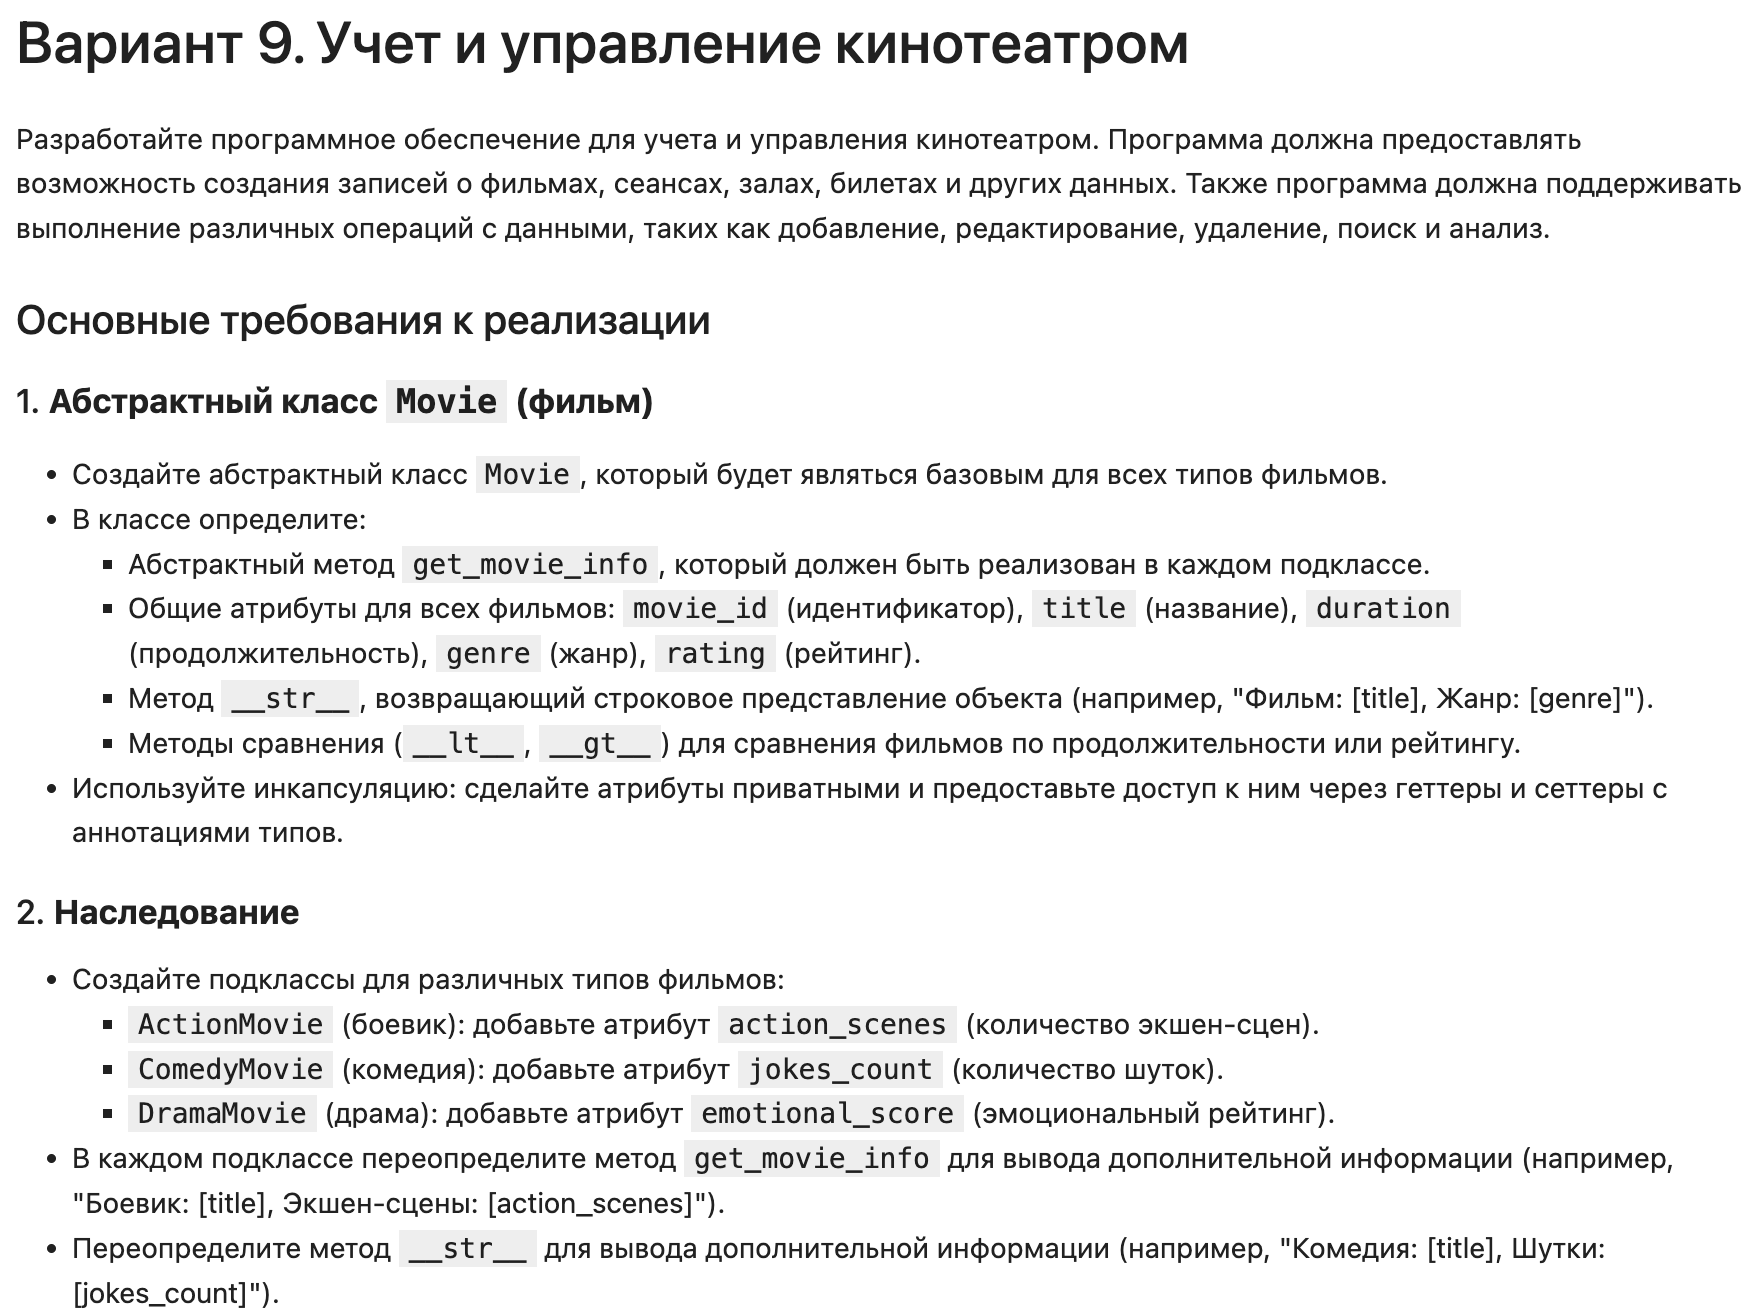

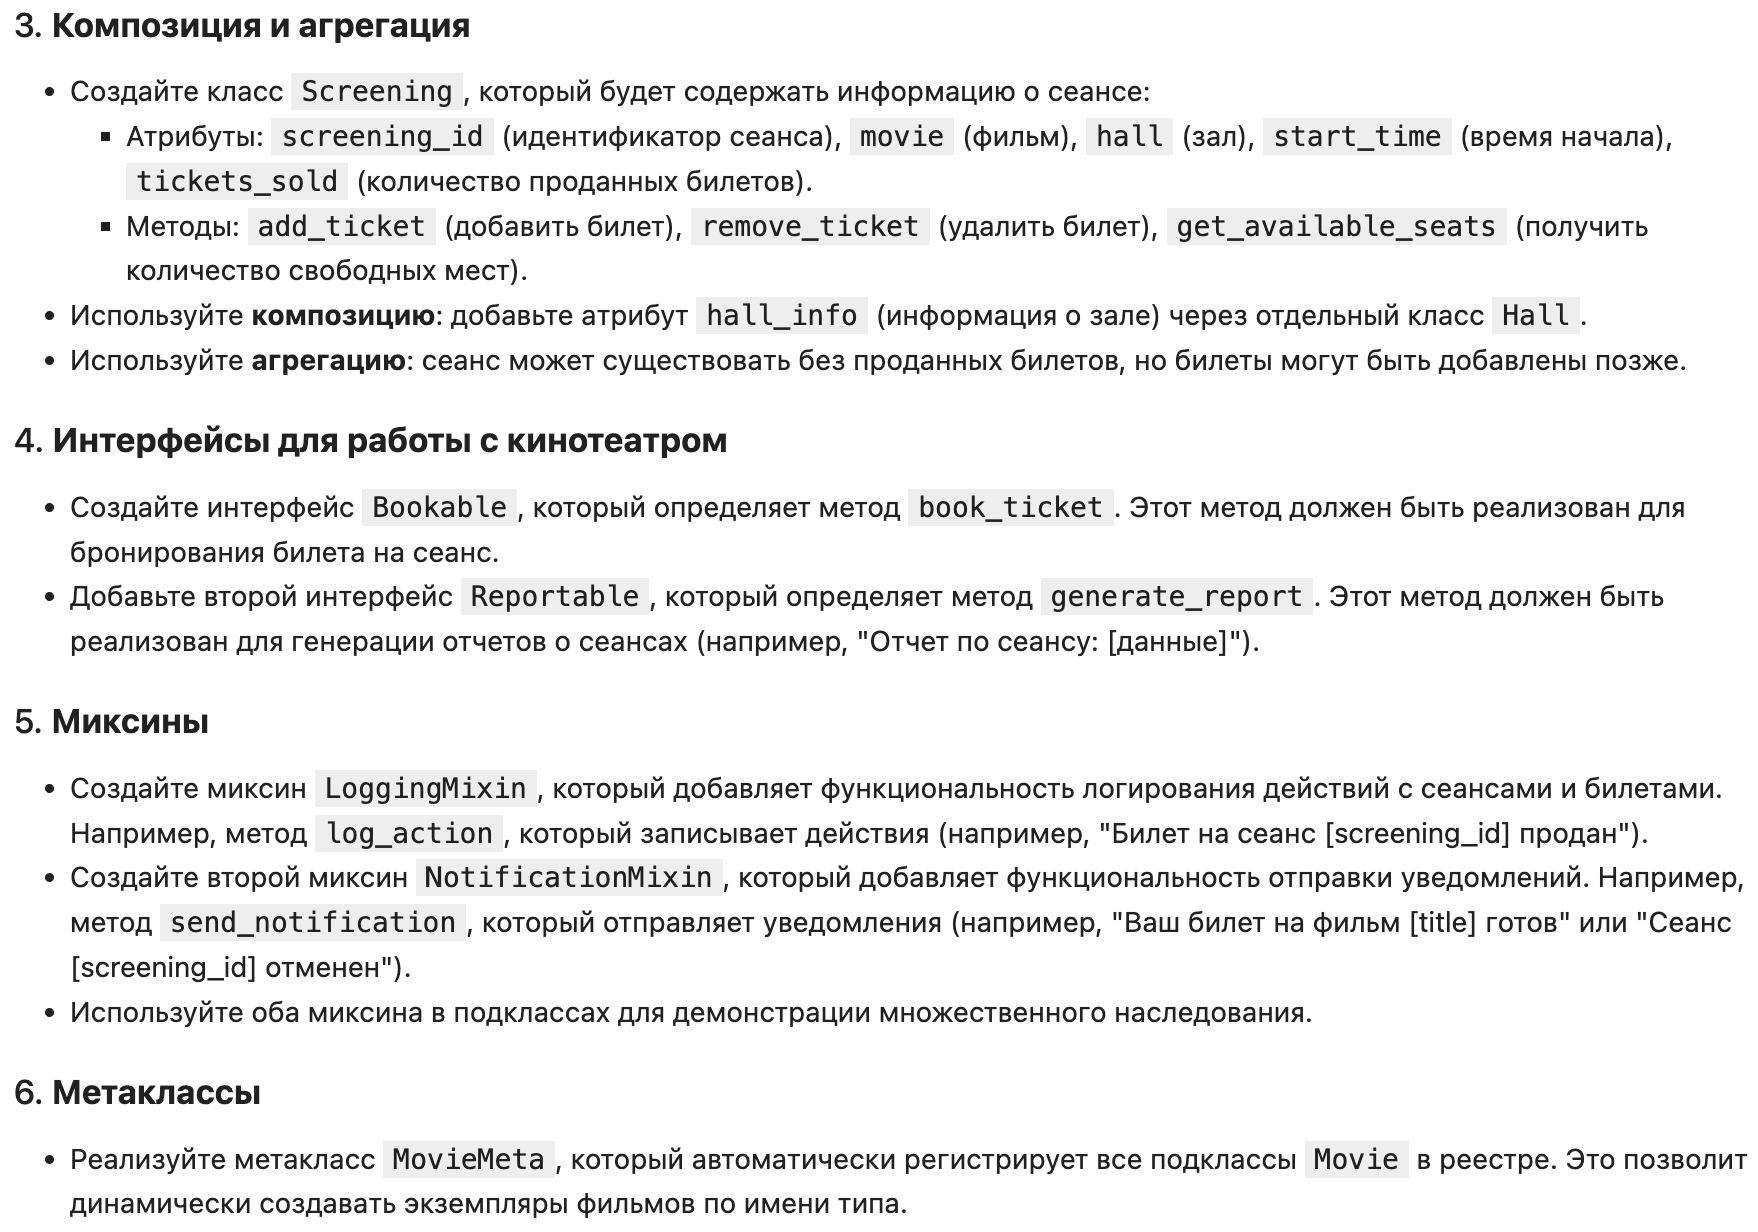

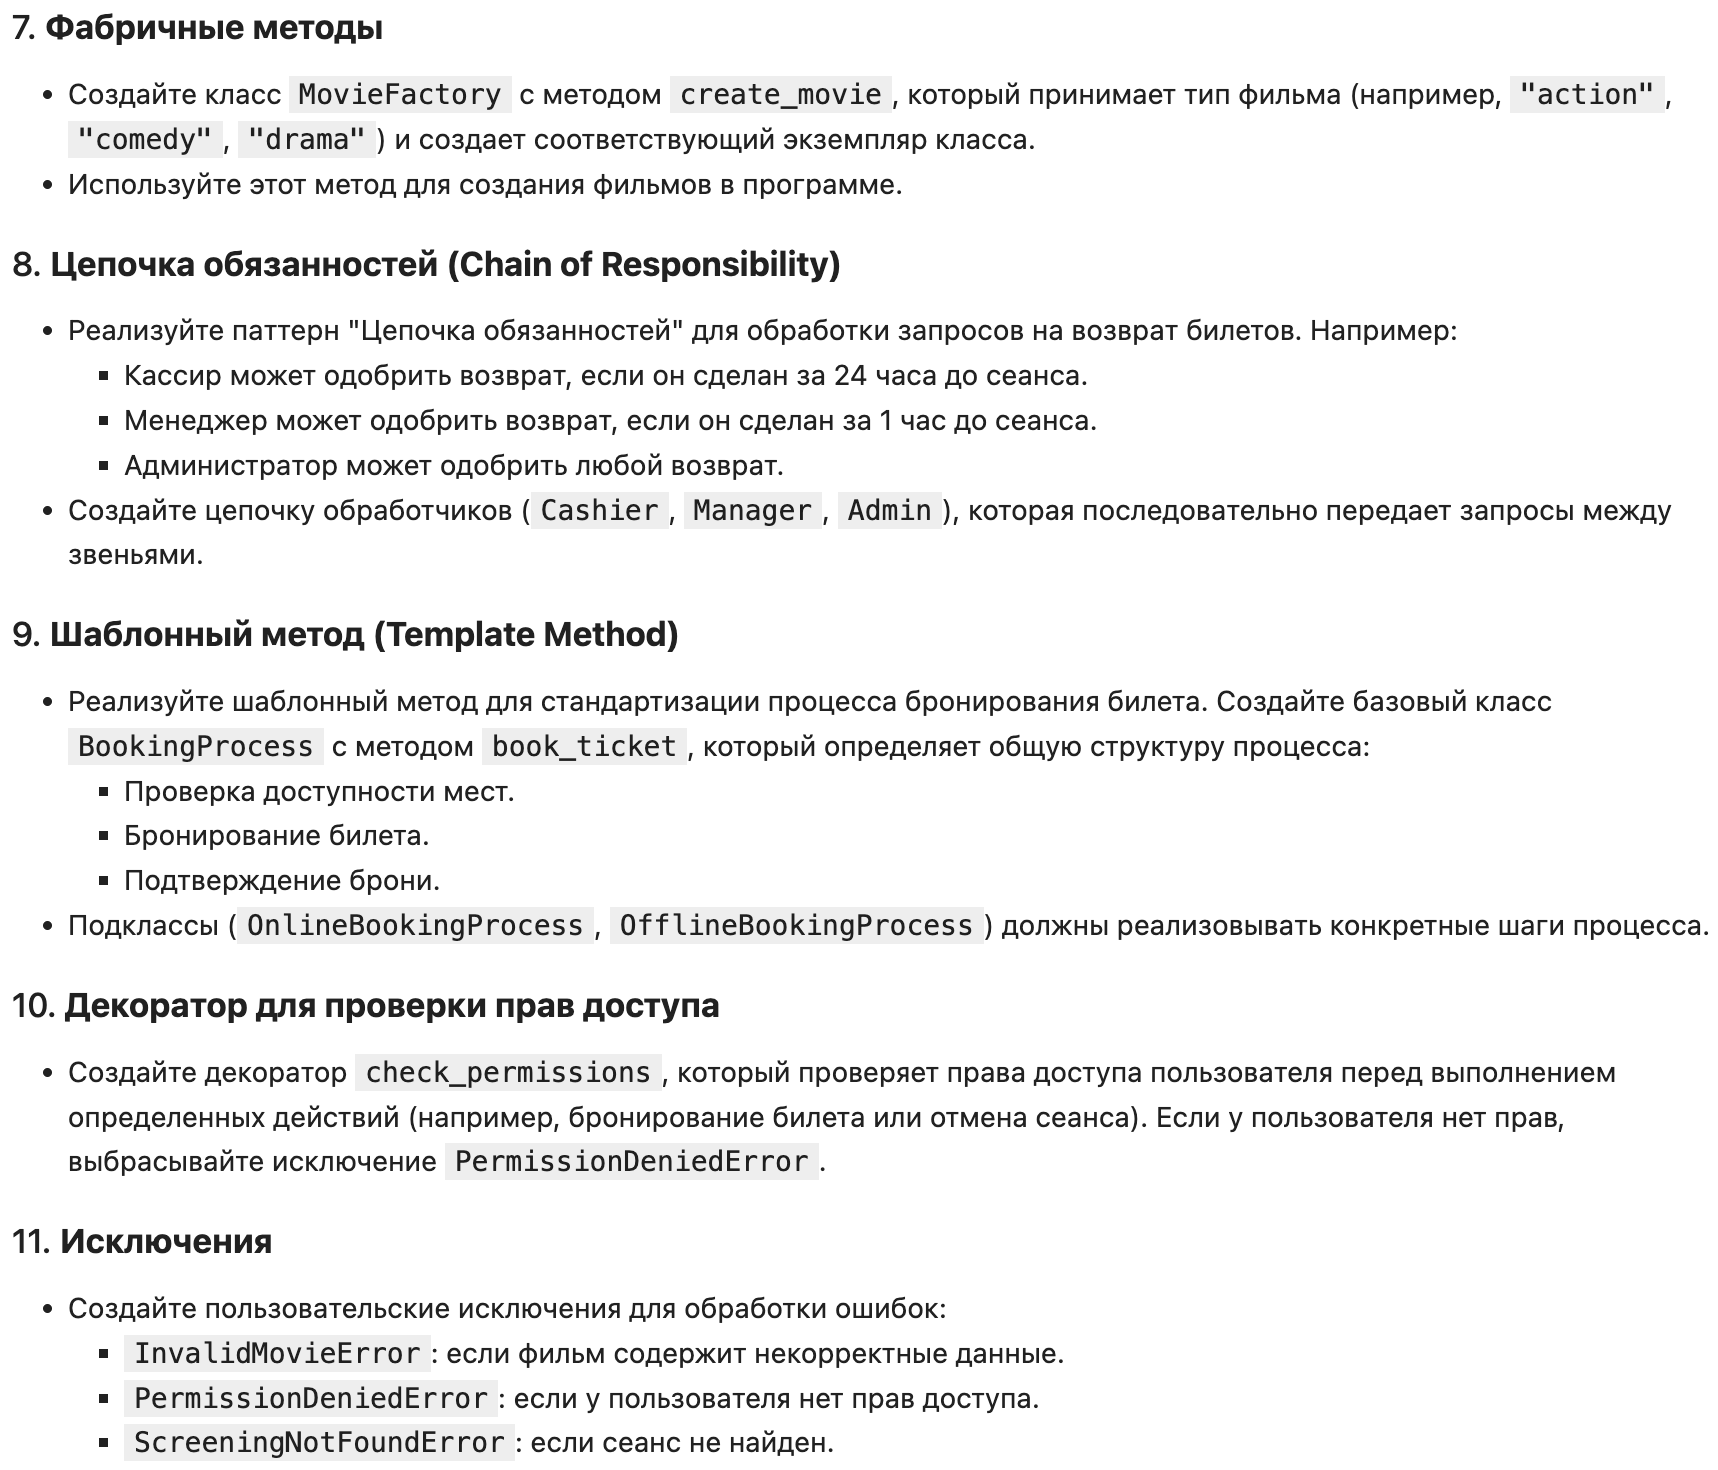

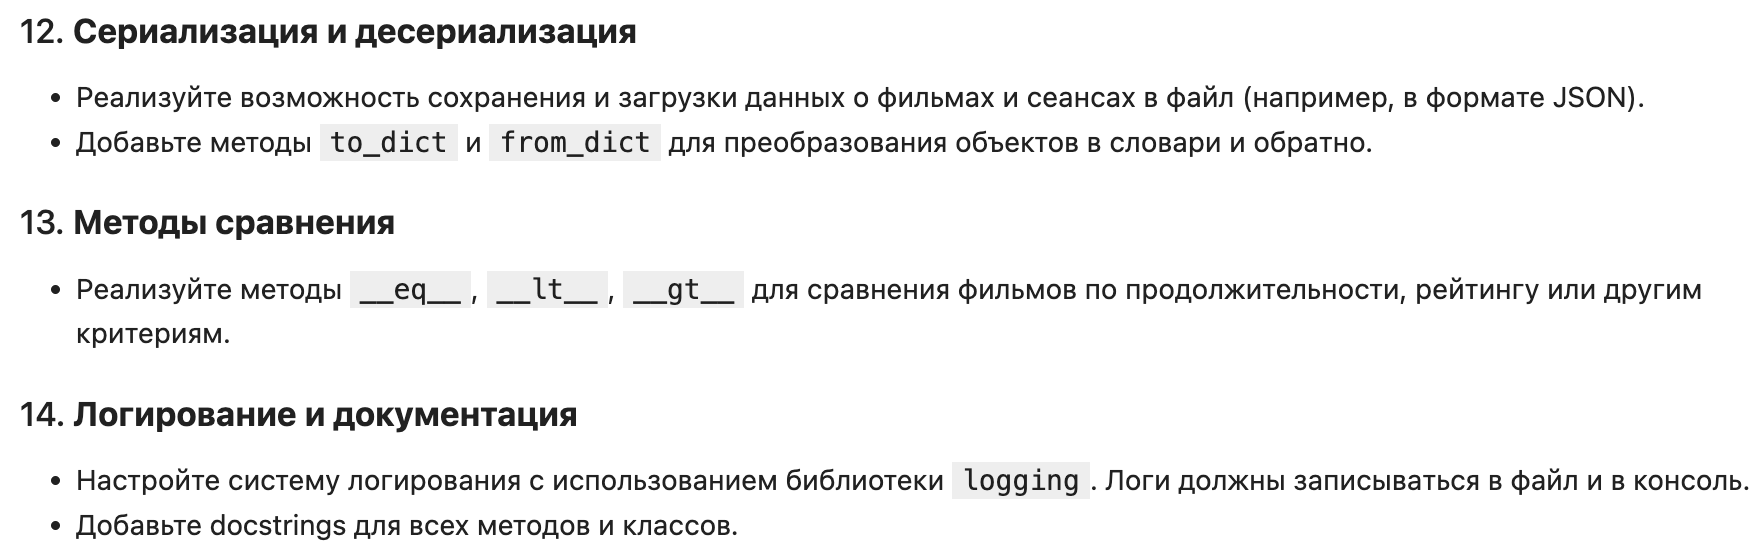

In [13]:
import logging
import json
from abc import ABC, ABCMeta, abstractmethod
from datetime import datetime, timedelta
from typing import Dict, List
from functools import wraps


logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

try:
    file_handler = logging.FileHandler('cinema.log')
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
except PermissionError as e:
    print(f"Error: Cannot write to cinema.log: {e}")
    logger.addHandler(logging.NullHandler())  

console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)


class InvalidMovieError(Exception):
    """Исключение для некорректных данных фильма"""
    pass

class PermissionDeniedError(Exception):
    """Исключение для отсутствия прав доступа"""
    pass

class ScreeningNotFoundError(Exception):
    """Исключение для ненайденного сеанса"""
    pass


class Bookable(ABC):
    @abstractmethod
    def book_ticket(self):
        """Бронирование билета"""
        pass

class Reportable(ABC):
    @abstractmethod
    def generate_report(self):
        """Генерация отчета"""
        pass

class LoggingMixin:
    def log_action(self, action: str) -> None:
        """Логирование действия"""
        logger.info(f"Action: {action}")

class NotificationMixin:
    def send_notification(self, message: str) -> None:
        """Отправка уведомления"""
        logger.info(f"Notification: {message}")
        print(f"Notification sent: {message}")

class MovieMeta(ABCMeta):
    _registry = {}

    def __new__(mcs, name, bases, attrs):
        new_cls = super().__new__(mcs, name, bases, attrs)
        if name != "Movie":
            mcs._registry[name.lower()] = new_cls
        return new_cls

    @classmethod
    def get_class(mcs, movie_type: str):
        """Получение класса по имени"""
        return mcs._registry.get(movie_type.lower())

class Movie(ABC, metaclass=MovieMeta):
    """Абстрактный класс для фильмов"""
    
    def __init__(self, movie_id: str, title: str, duration: int, genre: str, rating: float):
        if not title or duration <= 0 or rating < 0 or rating > 10:
            raise InvalidMovieError("Некорректные данные фильма")
        self._movie_id = movie_id
        self._title = title
        self._duration = duration
        self._genre = genre
        self._rating = rating

    @abstractmethod
    def get_movie_info(self) -> str:
        """Получение информации о фильме"""
        pass

    def __str__(self) -> str:
        return f"Фильм: {self._title}, Жанр: {self._genre}"

    def __lt__(self, other: 'Movie') -> bool:
        return self._rating < other._rating

    def __gt__(self, other: 'Movie') -> bool:
        return self._rating > other._rating

    def __eq__(self, other: 'Movie') -> bool:
        return self._movie_id == other._movie_id

    @property
    def movie_id(self) -> str:
        return self._movie_id

    @property
    def title(self) -> str:
        return self._title

    @property
    def rating(self) -> float:
        return self._rating

    @title.setter
    def title(self, new_title: str) -> None:
        if not new_title:
            raise InvalidMovieError("Название не может быть пустым")
        self._title = new_title

    def to_dict(self) -> Dict:
        """Преобразование объекта в словарь"""
        return {
            "movie_id": self._movie_id,
            "title": self._title,
            "duration": self._duration,
            "genre": self._genre,
            "rating": self._rating,
            "type": self.__class__.__name__.lower()
        }

    @classmethod
    def from_dict(cls, data: Dict) -> 'Movie':
        """Создание объекта из словаря"""
        movie_type = data.get("type")
        movie_class = MovieMeta.get_class(movie_type)
        if movie_class:
            return movie_class(
                data["movie_id"], data["title"], data["duration"],
                data["genre"], data["rating"], *data.get(movie_type[:-5], [])
            )
        raise InvalidMovieError(f"Неизвестный тип фильма: {movie_type}")

class ActionMovie(Movie):
    """Класс для боевиков"""
    
    def __init__(self, movie_id: str, title: str, duration: int, genre: str, rating: float, action_scenes: int):
        super().__init__(movie_id, title, duration, genre, rating)
        self._action_scenes = action_scenes

    def get_movie_info(self) -> str:
        return f"Боевик: {self._title}, Экшен-сцены: {self._action_scenes}"

    def __str__(self) -> str:
        return f"Боевик: {self._title}, Жанр: {self._genre}, Экшен-сцены: {self._action_scenes}"

    def to_dict(self) -> Dict:
        data = super().to_dict()
        data["action_scenes"] = self._action_scenes
        return data

class ComedyMovie(Movie):
    """Класс для комедий"""
    
    def __init__(self, movie_id: str, title: str, duration: int, genre: str, rating: float, jokes_count: int):
        super().__init__(movie_id, title, duration, genre, rating)
        self._jokes_count = jokes_count

    def get_movie_info(self) -> str:
        return f"Комедия: {self._title}, Шутки: {self._jokes_count}"

    def __str__(self) -> str:
        return f"Комедия: {self._title}, Жанр: {self._genre}, Шутки: {self._jokes_count}"

    def to_dict(self) -> Dict:
        data = super().to_dict()
        data["jokes_count"] = self._jokes_count
        return data

class DramaMovie(Movie):
    """Класс для драм"""
    
    def __init__(self, movie_id: str, title: str, duration: int, genre: str, rating: float, emotional_score: float):
        super().__init__(movie_id, title, duration, genre, rating)
        self._emotional_score = emotional_score

    def get_movie_info(self) -> str:
        return f"Драма: {self._title}, Эмоциональный рейтинг: {self._emotional_score}"

    def __str__(self) -> str:
        return f"Драма: {self._title}, Жанр: {self._genre}, Эмоциональный рейтинг: {self._emotional_score}"

    def to_dict(self) -> Dict:
        data = super().to_dict()
        data["emotional_score"] = self._emotional_score
        return data

class Hall:
    """Класс для залов кинотеатра"""
    
    def __init__(self, hall_id: str, name: str,

 capacity: int):
        self.hall_id = hall_id
        self.name = name
        self.capacity = capacity

    def to_dict(self) -> Dict:
        return {
            "hall_id": self.hall_id,
            "name": self.name,
            "capacity": self.capacity
        }

    @classmethod
    def from_dict(cls, data: Dict) -> 'Hall':
        return cls(data["hall_id"], data["name"], data["capacity"])

class Screening(Bookable, Reportable, LoggingMixin, NotificationMixin):
    """Класс для сеансов"""
    
    def __init__(self, screening_id: str, movie: Movie, hall: Hall, start_time: datetime):
        self.screening_id = screening_id
        self.movie = movie
        self.hall = hall
        self.start_time = start_time
        self.tickets_sold = 0
        self.log_action(f"Создан сеанс {screening_id} для {movie.title}")

    def book_ticket(self) -> bool:
        """Бронирование билета"""
        if self.tickets_sold < self.hall.capacity:
            self.tickets_sold += 1
            self.log_action(f"Билет продан на сеанс {self.screening_id}")
            self.send_notification(f"Ваш билет на фильм {self.movie.title} готов")
            return True
        return False

    def remove_ticket(self) -> bool:
        """Удаление билета"""
        if self.tickets_sold > 0:
            self.tickets_sold -= 1
            self.log_action(f"Билет возвращен для сеанса {self.screening_id}")
            self.send_notification(f"Билет на сеанс {self.screening_id} возвращен")
            return True
        return False

    def get_available_seats(self) -> int:
        """Получение количества свободных мест"""
        return self.hall.capacity - self.tickets_sold

    def generate_report(self) -> str:
        """Генерация отчета о сеансе"""
        return (f"Сеанс {self.screening_id}: Фильм: {self.movie.title}, "
                f"Зал: {self.hall.name}, Билеты: {self.tickets_sold}, "
                f"Свободно мест: {self.get_available_seats()}")

    def to_dict(self) -> Dict:
        return {
            "screening_id": self.screening_id,
            "movie": self.movie.to_dict(),
            "hall": self.hall.to_dict(),
            "start_time": self.start_time.isoformat(),
            "tickets_sold": self.tickets_sold
        }

    @classmethod
    def from_dict(cls, data: Dict) -> 'Screening':
        movie = Movie.from_dict(data["movie"])
        hall = Hall.from_dict(data["hall"])
        start_time = datetime.fromisoformat(data["start_time"])
        screening = cls(data["screening_id"], movie, hall, start_time)
        screening.tickets_sold = data["tickets_sold"]
        return screening

class MovieFactory:
    """Фабрика для создания фильмов"""
    
    @staticmethod
    def create_movie(movie_type: str, movie_id: str, title: str, duration: int, genre: str, rating: float, *args) -> Movie:
        movie_class = MovieMeta.get_class(movie_type)
        if movie_class:
            return movie_class(movie_id, title, duration, genre, rating, *args)
        raise InvalidMovieError(f"Неизвестный тип фильма: {movie_type}")

class RefundHandler(ABC):
    """Абстрактный обработчик возврата билетов"""
    
    def __init__(self, successor: 'RefundHandler' = None):
        self._successor = successor

    @abstractmethod
    def handle_refund(self, screening: Screening, refund_time: datetime) -> bool:
        """Обработка запроса на возврат"""
        pass

class Cashier(RefundHandler):
    """Кассир для обработки возвратов"""
    
    def handle_refund(self, screening: Screening, refund_time: datetime) -> bool:
        if refund_time < screening.start_time - timedelta(hours=24):
            screening.remove_ticket()
            logger.info(f"Возврат одобрен кассиром для сеанса {screening.screening_id}")
            return True
        elif self._successor:
            return self._successor.handle_refund(screening, refund_time)
        return False

class Manager(RefundHandler):
    """Менеджер для обработки возвратов"""
    
    def handle_refund(self, screening: Screening, refund_time: datetime) -> bool:
        if refund_time < screening.start_time - timedelta(hours=1):
            screening.remove_ticket()
            logger.info(f"Возврат одобрен менеджером для сеанса {screening.screening_id}")
            return True
        elif self._successor:
            return self._successor.handle_refund(screening, refund_time)
        return False

class Admin(RefundHandler):
    """Администратор для обработки возвратов"""
    
    def handle_refund(self, screening: Screening, refund_time: datetime) -> bool:
        screening.remove_ticket()
        logger.info(f"Возврат одобрен администратором для сеанса {screening.screening_id}")
        return True

class BookingProcess(ABC):
    """Базовый класс для процесса бронирования"""
    
    def book_ticket(self, screening: Screening) -> bool:
        """Шаблонный метод для бронирования"""
        if self.check_availability(screening):
            if self.reserve_ticket(screening):
                self.confirm_booking(screening)
                return True
        return False

    @abstractmethod
    def check_availability(self, screening: Screening) -> bool:
        """Проверка доступности мест"""
        pass

    @abstractmethod
    def reserve_ticket(self, screening: Screening) -> bool:
        """Резервирование билета"""
        pass

    @abstractmethod
    def confirm_booking(self, screening: Screening) -> None:
        """Подтверждение бронирования"""
        pass

class OnlineBookingProcess(BookingProcess):
    """Онлайн-бронирование"""
    
    def check_availability(self, screening: Screening) -> bool:
        available = screening.get_available_seats() > 0
        logger.info(f"Проверка доступности (онлайн): {'Доступно' if available else 'Нет мест'}")
        return available

    def reserve_ticket(self, screening: Screening) -> bool:
        return screening.book_ticket()

    def confirm_booking(self, screening: Screening) -> None:
        logger.info(f"Онлайн-бронирование подтверждено для сеанса {screening.screening_id}")

class OfflineBookingProcess(BookingProcess):
    """Оффлайн-бронирование"""
    
    def check_availability(self, screening: Screening) -> bool:
        available = screening.get_available_seats() > 0
        logger.info(f"Проверка доступности (оффлайн): {'Доступно' if available else 'Нет мест'}")
        return available

    def reserve_ticket(self, screening: Screening) -> bool:
        return screening.book_ticket()

    def confirm_booking(self, screening: Screening) -> None:
        logger.info(f"Оффлайн-бронирование подтверждено для сеанса {screening.screening_id}")

def check_permissions(required_role: str):
    """Декоратор для проверки прав доступа"""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            user_role = kwargs.get("user_role", args[1] if len(args) > 1 else None)
            if user_role != required_role:
                raise PermissionDeniedError(f"Требуется роль {required_role}")
            return func(*args, **kwargs)
        return wrapper
    return decorator

class Cinema:
    """Класс для управления кинотеатром"""
    
    def __init__(self):
        self.movies: List[Movie] = []
        self.screenings: List[Screening] = []
        self.refund_chain = Cashier(Manager(Admin()))
        self.log_action("Кинотеатр инициализирован")

    def add_movie(self, movie: Movie) -> None:
        """Добавление фильма"""
        self.movies.append(movie)
        self.log_action(f"Добавлен фильм: {movie.title}")

    def remove_movie(self, movie_id: str) -> None:
        """Удаление фильма"""
        self.movies = [m for m in self.movies if m.movie_id != movie_id]
        self.log_action(f"Фильм удален: {movie_id}")

    def add_screening(self, screening: Screening) -> None:
        """Добавление сеанса"""
        self.screenings.append(screening)
        self.log_action(f"Добавлен сеанс: {screening.screening_id}")

    def search_movies(self, title: str) -> List[Movie]:
        """Поиск фильмов по названию"""
        result = [m for m in self.movies if title.lower() in m.title.lower()]
        self.log_action(f"Поиск фильмов по запросу: {title}, найдено: {len(result)}")
        return result

    @check_permissions("cashier")
    def book_ticket(self, screening_id: str, user_role: str) -> bool:
        """Бронирование билета"""
        for screening in self.screenings:
            if screening.screening_id == screening_id:
                result = screening.book_ticket()
                self.log_action(f"Попытка бронирования на сеанс {screening_id}: {'Успешно' if result else 'Неудачно'}")
                return result
        raise ScreeningNotFoundError("Сеанс не найден")

    def refund_ticket(self, screening_id: str, refund_time: datetime) -> bool:
        """Возврат билета через цепочку обязанностей"""
        for screening in self.screenings:
            if screening.screening_id == screening_id:
                result = self.refund_chain.handle_refund(screening, refund_time)
                self.log_action(f"Попытка возврата билета на сеанс {screening_id}: {'Успешно' if result else 'Отклонено'}")
                return result
        raise ScreeningNotFoundError("Сеанс не найден")

    def save_data(self, filename: str) -> None:
        """Сохранение данных в файл"""
        try:
            data = {
                "movies": [m.to_dict() for m in self.movies],
                "screenings": [s.to_dict() for s in self.screenings]
            }
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False)
            self.log_action(f"Данные сохранены в {filename}")
        except PermissionError as e:
            logger.error(f"Ошибка записи в файл {filename}: {e}")
            raise

    def load_data(self, filename: str) -> None:
        """Загрузка данных из файла"""
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                data = json.load(f)
            self.movies = [Movie.from_dict(m) for m in data["movies"]]
            self.screenings = [Screening.from_dict(s) for s in data["screenings"]]
            self.log_action(f"Данные загружены из {filename}")
        except FileNotFoundError:
            logger.error(f"Файл {filename} не найден")
            raise
        except json.JSONDecodeError:
            logger.error(f"Ошибка чтения JSON из {filename}")
            raise

    def log_action(self, action: str) -> None:
        """Логирование действия"""
        logger.info(f"Action: {action}")


logger.info("Запуск приложения кинотеатра")
cinema = Cinema()
factory = MovieFactory()

try:
   
    action = factory.create_movie("actionmovie", "m1", "Mad Max", 120, "Action", 8.5, 10)
    comedy = factory.create_movie("comedymovie", "m2", "Superbad", 100, "Comedy", 7.8, 50)
    drama = factory.create_movie("dramamovie", "m3", "The Godfather", 150, "Drama", 9.2, 8.0)
    logger.info("Фильмы созданы")

    cinema.add_movie(action)
    cinema.add_movie(comedy)
    cinema.add_movie(drama)


    hall = Hall("h1", "Main Hall", 100)
    screening1 = Screening("s1", action, hall, datetime(2025, 4, 24, 18, 0))
    screening2 = Screening("s2", comedy, hall, datetime(2025, 4, 24, 20, 0))
    cinema.add_screening(screening1)
    cinema.add_screening(screening2)


    print("Фильмы в кинотеатре:")
    for movie in cinema.movies:
        print(movie.get_movie_info())
  
    print("\nСеансы:")
    for screening in cinema.screenings:
        print(screening.generate_report())


    online_booking = OnlineBookingProcess()
    offline_booking = OfflineBookingProcess()
    online_booking.book_ticket(screening1)
    offline_booking.book_ticket(screening2)

    print("\nОбновленные отчеты:")
    for screening in cinema.screenings:
        print(screening.generate_report())

    refund_time = datetime(2025, 4, 24, 16, 0)
    cinema.refund_ticket("s1", refund_time)

    print("\nПоиск фильмов с 'Mad' в названии:")
    for movie in cinema.search_movies("Mad"):
        print(movie.get_movie_info())

       
    cinema.save_data("cinema_data.json")
    logger.info("Приложение завершило выполнение")

except (InvalidMovieError, PermissionDeniedError, ScreeningNotFoundError, FileNotFoundError, PermissionError) as e:
    logger.error(f"Ошибка: {e}")
    print(f"Ошибка: {e}")

2025-04-26 05:36:59,070 - INFO - Запуск приложения кинотеатра
2025-04-26 05:36:59,070 - INFO - Запуск приложения кинотеатра
2025-04-26 05:36:59,073 - INFO - Action: Кинотеатр инициализирован
2025-04-26 05:36:59,073 - INFO - Action: Кинотеатр инициализирован
2025-04-26 05:36:59,075 - INFO - Фильмы созданы
2025-04-26 05:36:59,075 - INFO - Фильмы созданы
2025-04-26 05:36:59,076 - INFO - Action: Добавлен фильм: Mad Max
2025-04-26 05:36:59,076 - INFO - Action: Добавлен фильм: Mad Max
2025-04-26 05:36:59,077 - INFO - Action: Добавлен фильм: Superbad
2025-04-26 05:36:59,077 - INFO - Action: Добавлен фильм: Superbad
2025-04-26 05:36:59,077 - INFO - Action: Добавлен фильм: The Godfather
2025-04-26 05:36:59,077 - INFO - Action: Добавлен фильм: The Godfather
2025-04-26 05:36:59,078 - INFO - Action: Создан сеанс s1 для Mad Max
2025-04-26 05:36:59,078 - INFO - Action: Создан сеанс s1 для Mad Max
2025-04-26 05:36:59,079 - INFO - Action: Создан сеанс s2 для Superbad
2025-04-26 05:36:59,079 - INFO - A

Фильмы в кинотеатре:
Боевик: Mad Max, Экшен-сцены: 10
Комедия: Superbad, Шутки: 50
Драма: The Godfather, Эмоциональный рейтинг: 8.0

Сеансы:
Сеанс s1: Фильм: Mad Max, Зал: Main Hall, Билеты: 0, Свободно мест: 100
Сеанс s2: Фильм: Superbad, Зал: Main Hall, Билеты: 0, Свободно мест: 100
Notification sent: Ваш билет на фильм Mad Max готов
Notification sent: Ваш билет на фильм Superbad готов

Обновленные отчеты:
Сеанс s1: Фильм: Mad Max, Зал: Main Hall, Билеты: 1, Свободно мест: 99
Сеанс s2: Фильм: Superbad, Зал: Main Hall, Билеты: 1, Свободно мест: 99
Notification sent: Билет на сеанс s1 возвращен

Поиск фильмов с 'Mad' в названии:
Боевик: Mad Max, Экшен-сцены: 10
